# Clustering Smartphone Cases

## Preparation

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import adjusted_rand_score, silhouette_score

from src import akeneo, akeneo_clustering as ac, clustering, config

In [2]:
cache = akeneo.create_cache_from_env()

In [3]:
data_dir = config.dir_data / "clustering-results" / "skill-phones"
data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
family = "smartphones"
channel = "default"
lang = "en_US"

### Products

In [5]:
products = ac.parse_products(
    cache,
    product_families=[family],
    attribute_types=ac.TYPES_NUMERICAL + ac.TYPES_CATEGORICAL + ac.TYPES_MULTI + ac.TYPES_TEXT,
)
products_multi_as_single = ac.transform_multi_to_single_cat(products)

n = len(products)

products_df = pd.DataFrame(products)
products_multi_as_single_df = pd.DataFrame(products_multi_as_single)

In [6]:
labels_want_generations = products_df["__categories__"].map(lambda x: x[-1].split("_")[0]).to_numpy()
k_generations = len(set(labels_want_generations))
pd.Series(labels_want_generations).value_counts(), f"k = {k_generations}"

(s21    21
 s20    17
 s22     4
 dtype: int64,
 'k = 3')

In [7]:
labels_want_models = products_df["__categories__"].map(lambda x: x[-1]).to_numpy()
k_models = len(set(labels_want_models))
pd.Series(labels_want_models).value_counts(), f"k = {k_models}"

(s21          7
 s21_ultra    6
 s20          5
 s20_plus     5
 s20_ultra    4
 s21_plus     4
 s21_fe       4
 s20_fe       3
 s22          2
 s22_plus     1
 s22_ultra    1
 dtype: int64,
 'k = 11')

In [8]:
duplicates: dict[str, list[int]] = {}
for index, categories in products_df.to_dict()[ac.KEY_CATEGORIES].items():
    category = categories[0]
    if category[:4] != "dup_":
        continue

    if category not in duplicates:
        duplicates[category] = []
    duplicates[category].append(index)
duplicates

{'dup_s20': [1, 2],
 'dup_s20_ultra': [9, 10],
 'dup_s21_128': [18, 19],
 'dup_s21_256': [20, 21],
 'dup_s21_plus': [24, 25],
 'dup_s21_ultra': [32, 33]}

### Attributes

In [9]:
tmp = {
    "code": [],
    "name": [],
    "type": [],
    "typeclass": [],
    "required": [],
    "non-null": [],
    "unique": [],
}

attr_req = list(filter(lambda f: f.code == family, cache.families))[0].attribute_requirements[channel]

for attr_code, attr in akeneo.Attribute.to_dict(cache.attributes).items():
    if attr_code not in products_df.columns:
        continue

    typeclass = (
        "numerical"
        if attr.type in ac.TYPES_NUMERICAL
        else "categorical"
        if attr.type in ac.TYPES_CATEGORICAL
        else "multi"
        if attr.type in ac.TYPES_MULTI
        else "string"
        if attr.type in ac.TYPES_TEXT
        else "unknown"
    )

    tmp["code"].append(attr_code)
    tmp["name"].append(attr.labels[lang])
    tmp["type"].append(attr.type)
    tmp["typeclass"].append(typeclass)
    tmp["required"].append(attr_code in attr_req)
    tmp["non-null"].append(products_df[attr_code].count())
    tmp["unique"].append(products_df[attr_code].drop_duplicates().count())

attr_df = pd.DataFrame(tmp)
attr_df.sort_values(["required", "non-null"], ascending=[False, False])

,code,name,type,typeclass,required,non-null,unique
10,icecat_12435_fixed,Rear camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,4
11,icecat_12437_fixed,Front camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,3
25,icecat_1585,Display resolution,AttributeType.TEXT,string,True,42,4
37,icecat_1766_fixed,Product color,AttributeType.SELECT_MULTI,multi,True,42,15
64,icecat_27587,Rear camera type,AttributeType.SELECT_SINGLE,categorical,True,42,2
...,...,...,...,...,...,...,...
108,icecat_3807,Package height,AttributeType.METRIC,numerical,False,1,1
109,icecat_3808,Package width,AttributeType.METRIC,numerical,False,1,1
112,icecat_38332,Heart rate sensor,AttributeType.BOOL,categorical,False,1,1
137,icecat_4857,Battery weight,AttributeType.METRIC,numerical,False,1,1


In [10]:
cols = ["code", "typeclass", "non-null", "unique"]
attr_df[cols].groupby(["typeclass"]).agg({
    "code": "count",
    "non-null": "mean",
    "unique": "mean",
}).reset_index().round(1)

,typeclass,code,non-null,unique
0,categorical,106,28.2,1.3
1,multi,22,25.2,3.5
2,numerical,56,21.8,3.7
3,string,11,28.4,13.5


### Clustering & Metrics

In [11]:
def _calc_duplicates_match(labels) -> int:
    result = 0
    for _, indexes in duplicates.items():
        y1 = labels[indexes[0]]
        y2 = labels[indexes[1]]

        shared_clusters = len(y1.intersection(y2))
        all_clusters = len(y1.union(y2))

        if (shared_clusters+1) == all_clusters:
            result += 1
    
    return result

def calc_metrics(attr_codes, multi_as_single=False):
    dataset = (
        ac.dataset_from_records(products_df[attr_codes].to_dict("records"))
        if not multi_as_single
        else ac.dataset_from_records(products_multi_as_single_df[attr_codes].to_dict("records"))
    )
    prox_matrix = ac.calc_proximity_matrix(dataset)

    bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)
    biks = [
        clustering.BisectingKMeans(dataset, ac.Centroid, random_state=i)
        for i in range(1, 11)
    ]

    stabilities = []
    for k in range(2, len(dataset) + 1):
        values = []
        for bikk in biks:
            values.append(
                adjusted_rand_score(
                    bik.labels_flat(k),
                    bikk.labels_flat(k),
                )
            )
        stabilities.append(np.array(values).mean())
    stabilities = np.array(stabilities)

    qualities = []
    for k in range(2, len(dataset)):
        qualities.append(silhouette_score(prox_matrix, bik.labels_flat(k), metric="precomputed"))
    qualities = np.array(qualities)

    return {
        "stabilities": stabilities,
        "qualities": qualities,
        "match_gen": adjusted_rand_score(labels_want_generations, bik.labels_flat(k_generations)),
        "match_mod": adjusted_rand_score(labels_want_models, bik.labels_flat(k_models)),
        "match_dup": _calc_duplicates_match(bik.labels)
    }

In [12]:
def metrics_to_table(metric):
    return {
        "Stability": metric["stabilities"].mean(),
        "Quality Ø": metric["qualities"].mean(),
        "Quality Generations": metric["qualities"][k_generations - 2],
        "Quality Models": metric["qualities"][k_models - 2],
        "Match Generations": metric["match_gen"],
        "Match Models": metric["match_mod"],
        "Match Duplicates": metric["match_dup"],
    }

## Clusterings

In [13]:
tmp = {
    "num+cat": attr_df[attr_df["typeclass"].isin(["numerical", "categorical"])]["code"],
    "num+cat+mul": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi"])]["code"],
    "num+cat+str": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "string"])]["code"],
    "num+cat+mul+str": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi", "string"])]["code"],
    "str": attr_df[attr_df["typeclass"].isin(["string"])]["code"],
}

def metrics_make():
    return {
        "num+cat": calc_metrics(tmp["num+cat"]),
        "num+cat+mul": calc_metrics(tmp["num+cat+mul"]),
        "num+cat+mul as cat": calc_metrics(tmp["num+cat+mul"], True),
        "num+cat+str": calc_metrics(tmp["num+cat+str"]),
        "num+cat+mul+str": calc_metrics(tmp["num+cat+mul+str"]),
        "num+cat+mul+str as cat": calc_metrics(tmp["num+cat+mul+str"]),
        "str": calc_metrics(tmp["str"]),
    }
metrics = config.load_or_create(data_dir / "metrics.pkl", metrics_make)

In [14]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics.items()
}).transpose().style.highlight_max(color="lightgreen")

,Stability,Quality Ø,Quality Generations,Quality Models,Match Generations,Match Models,Match Duplicates
num+cat,0.979872,0.425714,0.308495,0.596459,0.652655,0.711868,5.000000
num+cat+mul,0.976366,0.407305,0.371450,0.569350,0.158205,0.695121,5.000000
num+cat+mul as cat,0.970658,0.402377,0.295292,0.527937,0.517806,0.680119,5.000000
num+cat+str,0.979380,0.411978,0.301878,0.576143,0.652655,0.658262,5.000000
num+cat+mul+str,0.916387,0.389135,0.352000,0.564347,0.158205,0.695121,6.000000
num+cat+mul+str as cat,0.916387,0.389135,0.352000,0.564347,0.158205,0.695121,6.000000
str,0.912915,0.338833,0.257010,0.401722,0.642564,0.871639,6.000000


In [14]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics.items()
}).transpose().round(2)

,Stability,Quality Ø,Quality Generations,Quality Models,Match Generations,Match Models,Match Duplicates
num+cat,0.98,0.43,0.31,0.60,0.65,0.71,5.0
num+cat+mul,0.98,0.41,0.37,0.57,0.16,0.70,5.0
num+cat+mul as cat,0.97,0.40,0.30,0.53,0.52,0.68,5.0
num+cat+str,0.98,0.41,0.30,0.58,0.65,0.66,5.0
num+cat+mul+str,0.92,0.39,0.35,0.56,0.16,0.70,6.0
num+cat+mul+str as cat,0.92,0.39,0.35,0.56,0.16,0.70,6.0
str,0.91,0.34,0.26,0.40,0.64,0.87,6.0


In [15]:
dataset = ac.dataset_from_records(products_df[tmp["num+cat"]].to_dict("records"))
bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)

In [16]:
labels = []
for prod in cache.products:
    if prod.family != family:
        continue
    titles = prod.values["icecat_title"]
    found = False
    for title in titles:
        if title.locale == lang:
            found = True
            labels.append(title.data)
            break
    if not found:
        labels.append("")
np.array(labels)

array(['Samsung Galaxy S20 SM-G980F 6.2" Android 10.0 4G USB Type-C 8 GB 128 GB 4000 mAh Gray',
       'Samsung Galaxy S20 6.2" Android 10.0 4G USB Type-C 8 GB 128 GB 4000 mAh Blue',
       'Samsung Galaxy S20 SM-G980F 6.2" Android 10.0 4G USB Type-C 8 GB 128 GB 4000 mAh Blue',
       'Samsung Galaxy S20 6.2" Android 10.0 4G USB Type-C 8 GB 128 GB 4000 mAh White',
       'Samsung Galaxy S20 SM-G980F 6.2" Android 10.0 4G USB Type-C 8 GB 128 GB 4000 mAh Pink',
       'Samsung Galaxy S20+ SM-G985F 6.7" Android 10.0 4G USB Type-C 8 GB 128 GB 4500 mAh Black',
       'Samsung Galaxy S20+ S20+ 6.7" Dual SIM Android 10.0 4G USB Type-C 8 GB 128 GB 4500 mAh Blue',
       'Samsung Galaxy S20+ 5G SM-G986B 6.7" Android 10.0 USB Type-C 12 GB 128 GB 4500 mAh Blue',
       'Samsung Galaxy S20+ SM-G985F 6.7" Android 10.0 4G USB Type-C 8 GB 128 GB 4500 mAh Blue',
       'Samsung Galaxy S20 Ultra 5G 6.9" Android 10.0 USB Type-C 16 GB 512 GB 5000 mAh Black',
       'Samsung Galaxy S20 Ultra 5G SM-G988B 6.

In [17]:
mpl.rcParams['figure.dpi'] = 300

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [95.0, 95.0, 105.0, 105.0],
  [80.0, 80.0, 100.0, 100.0],
  [60.0, 60.0, 90.0, 90.0],
  [32.5, 32.5, 75.0, 75.0],
  [10.0, 10.0, 53.75, 53.75],
  [135.0, 135.0, 145.0, 145.0],
  [140.0, 140.0, 155.0, 155.0],
  [125.0, 125.0, 147.5, 147.5],
  [115.0, 115.0, 136.25, 136.25],
  [165.0, 165.0, 175.0, 175.0],
  [185.0, 185.0, 195.0, 195.0],
  [170.0, 170.0, 190.0, 190.0],
  [205.0, 205.0, 215.0, 215.0],
  [225.0, 225.0, 235.0, 235.0],
  [245.0, 245.0, 255.0, 255.0],
  [230.0, 230.0, 250.0, 250.0],
  [210.0, 210.0, 240.0, 240.0],
  [180.0, 180.0, 225.0, 225.0],
  [125.625, 125.625, 202.5, 202.5],
  [265.0, 265.0, 275.0, 275.0],
  [285.0, 285.0, 295.0, 295.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [290.0, 290.0, 312.5, 312.5],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0, 360.0],
  [335.0, 335.0, 352.5, 352.

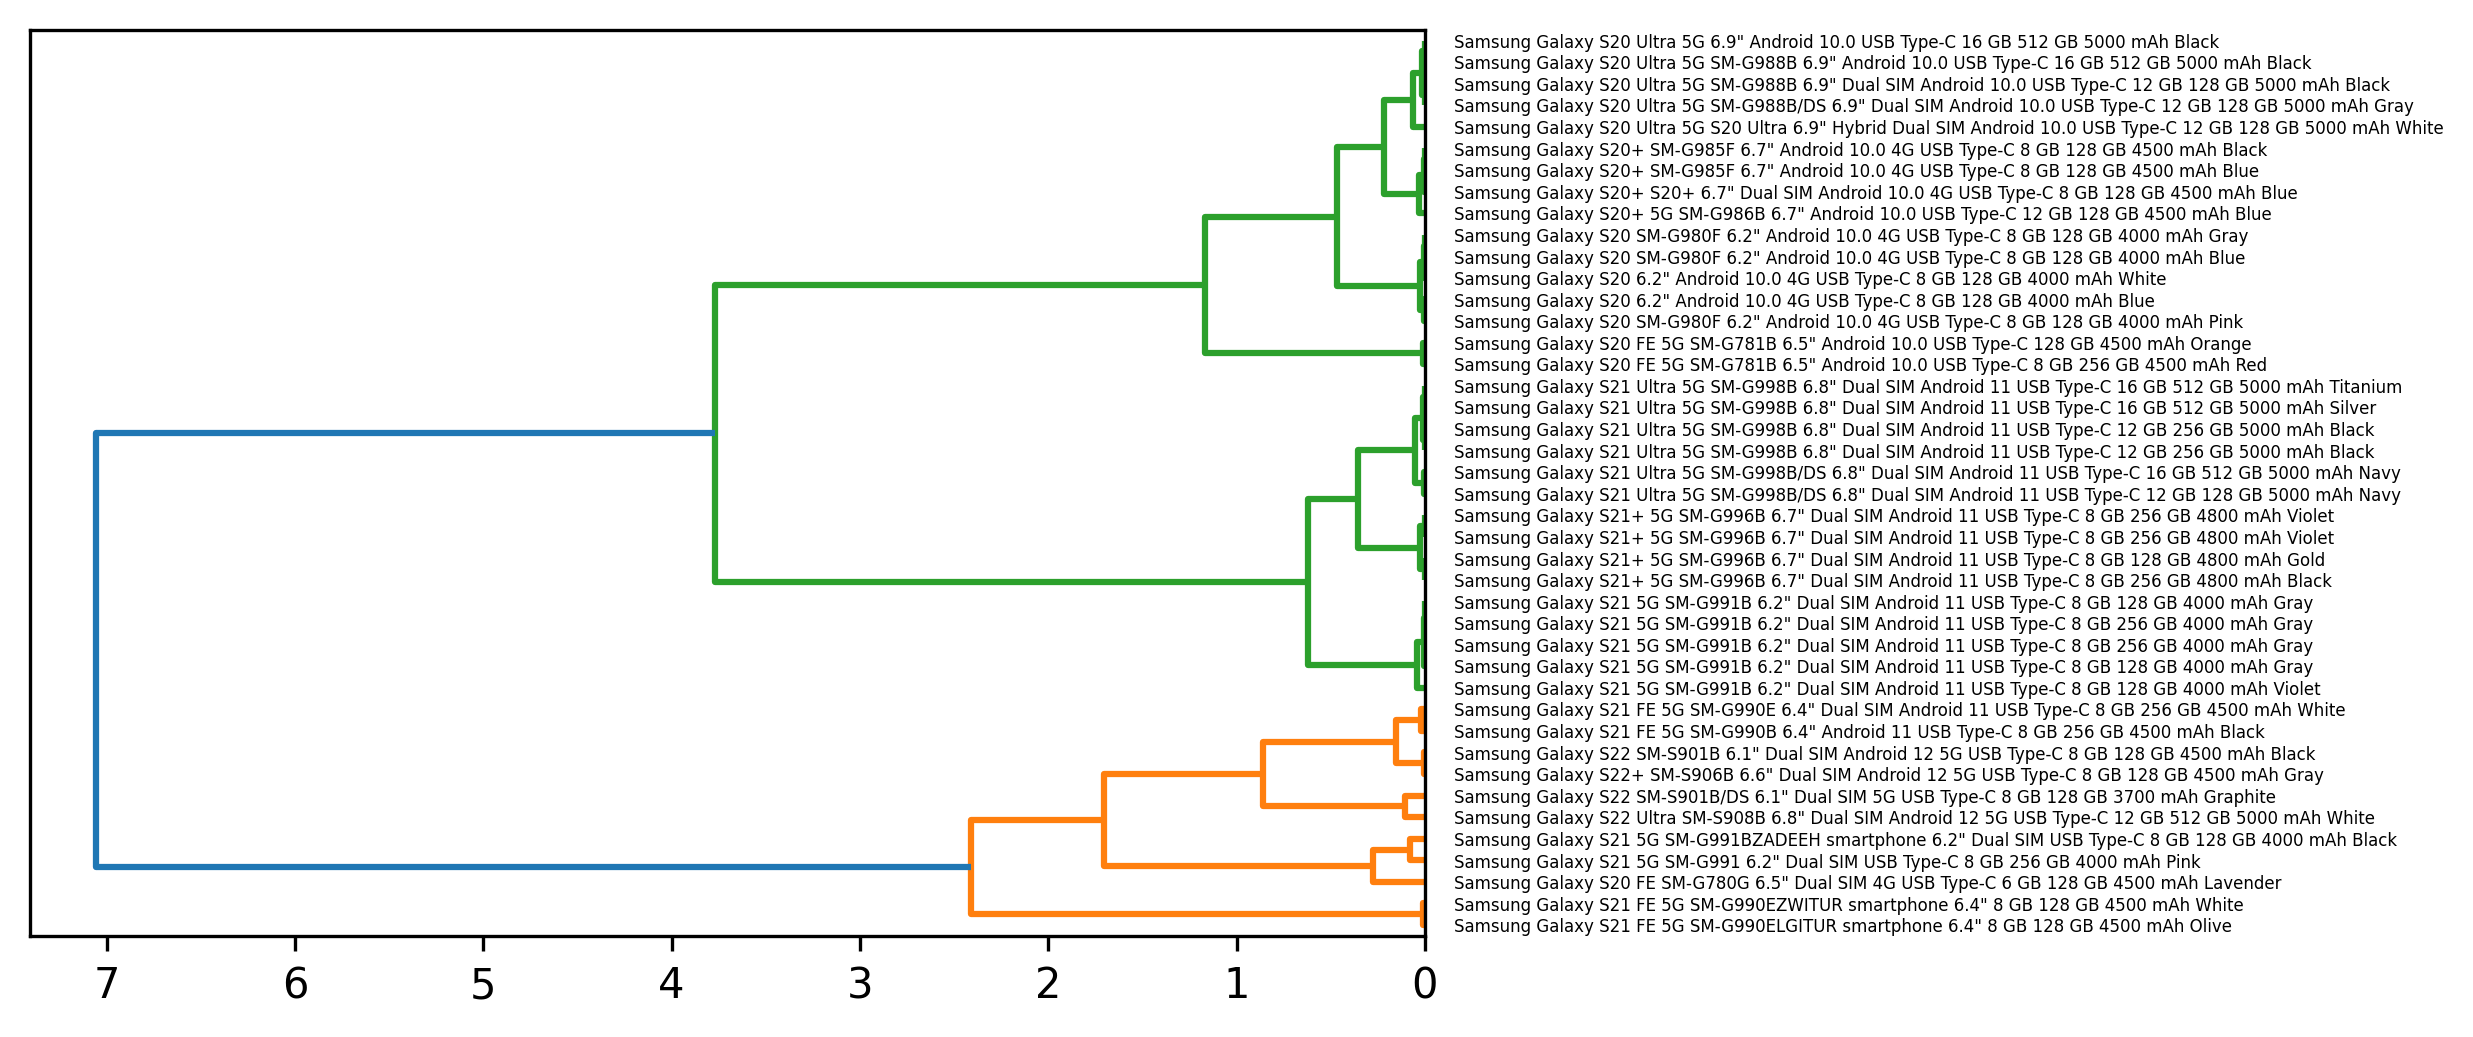

In [18]:
dendrogram(bik.dendrogram_matrix, labels=labels, leaf_font_size=4, orientation="left")

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [95.0, 95.0, 105.0, 105.0],
  [80.0, 80.0, 100.0, 100.0],
  [60.0, 60.0, 90.0, 90.0],
  [32.5, 32.5, 75.0, 75.0],
  [10.0, 10.0, 53.75, 53.75],
  [135.0, 135.0, 145.0, 145.0],
  [140.0, 140.0, 155.0, 155.0],
  [125.0, 125.0, 147.5, 147.5],
  [115.0, 115.0, 136.25, 136.25],
  [165.0, 165.0, 175.0, 175.0],
  [185.0, 185.0, 195.0, 195.0],
  [170.0, 170.0, 190.0, 190.0],
  [205.0, 205.0, 215.0, 215.0],
  [225.0, 225.0, 235.0, 235.0],
  [245.0, 245.0, 255.0, 255.0],
  [230.0, 230.0, 250.0, 250.0],
  [210.0, 210.0, 240.0, 240.0],
  [180.0, 180.0, 225.0, 225.0],
  [125.625, 125.625, 202.5, 202.5],
  [265.0, 265.0, 275.0, 275.0],
  [285.0, 285.0, 295.0, 295.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [290.0, 290.0, 312.5, 312.5],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0, 360.0],
  [335.0, 335.0, 352.5, 352.

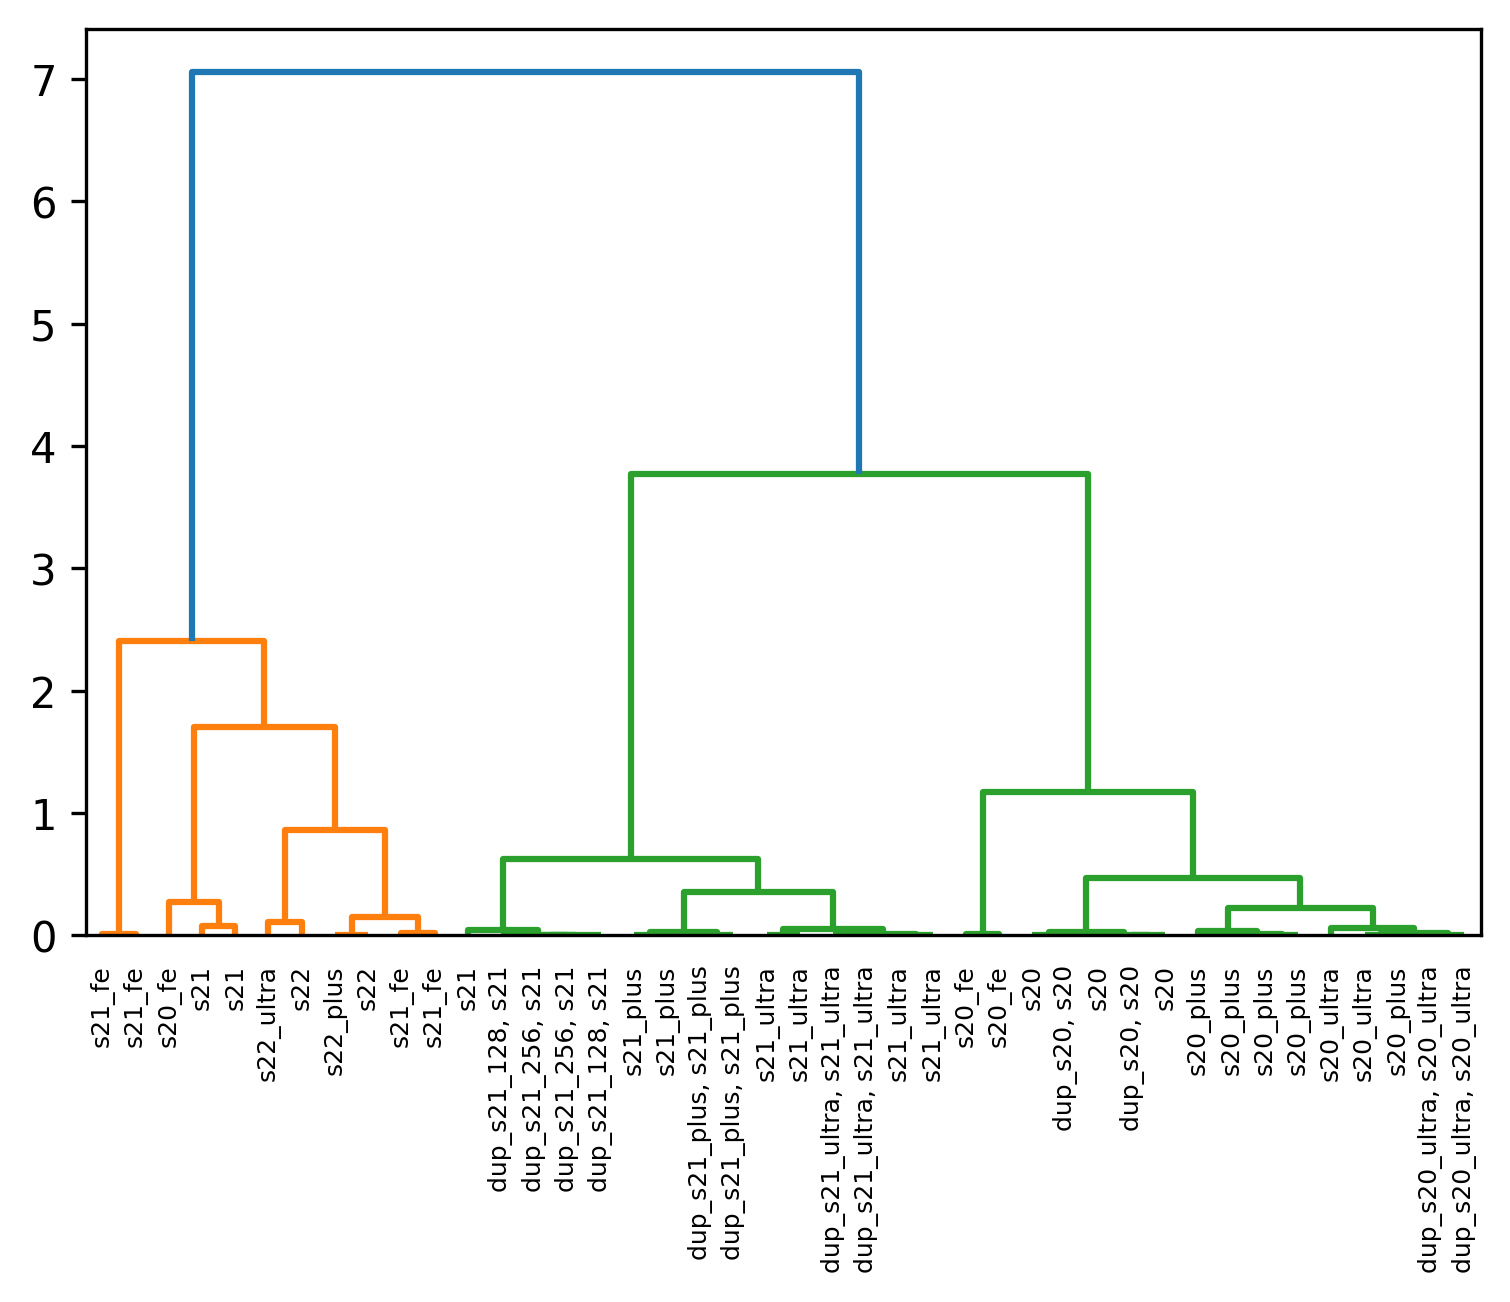

In [19]:
labels_simple = products_df[ac.KEY_CATEGORIES].map(lambda x: ", ".join(x)).to_list()
dendrogram(bik.dendrogram_matrix, labels=labels_simple, leaf_font_size=6)

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [95.0, 95.0, 105.0, 105.0],
  [80.0, 80.0, 100.0, 100.0],
  [60.0, 60.0, 90.0, 90.0],
  [32.5, 32.5, 75.0, 75.0],
  [10.0, 10.0, 53.75, 53.75],
  [135.0, 135.0, 145.0, 145.0],
  [140.0, 140.0, 155.0, 155.0],
  [125.0, 125.0, 147.5, 147.5],
  [115.0, 115.0, 136.25, 136.25],
  [165.0, 165.0, 175.0, 175.0],
  [185.0, 185.0, 195.0, 195.0],
  [170.0, 170.0, 190.0, 190.0],
  [205.0, 205.0, 215.0, 215.0],
  [225.0, 225.0, 235.0, 235.0],
  [245.0, 245.0, 255.0, 255.0],
  [230.0, 230.0, 250.0, 250.0],
  [210.0, 210.0, 240.0, 240.0],
  [180.0, 180.0, 225.0, 225.0],
  [125.625, 125.625, 202.5, 202.5],
  [265.0, 265.0, 275.0, 275.0],
  [285.0, 285.0, 295.0, 295.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [290.0, 290.0, 312.5, 312.5],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0, 360.0],
  [335.0, 335.0, 352.5, 352.

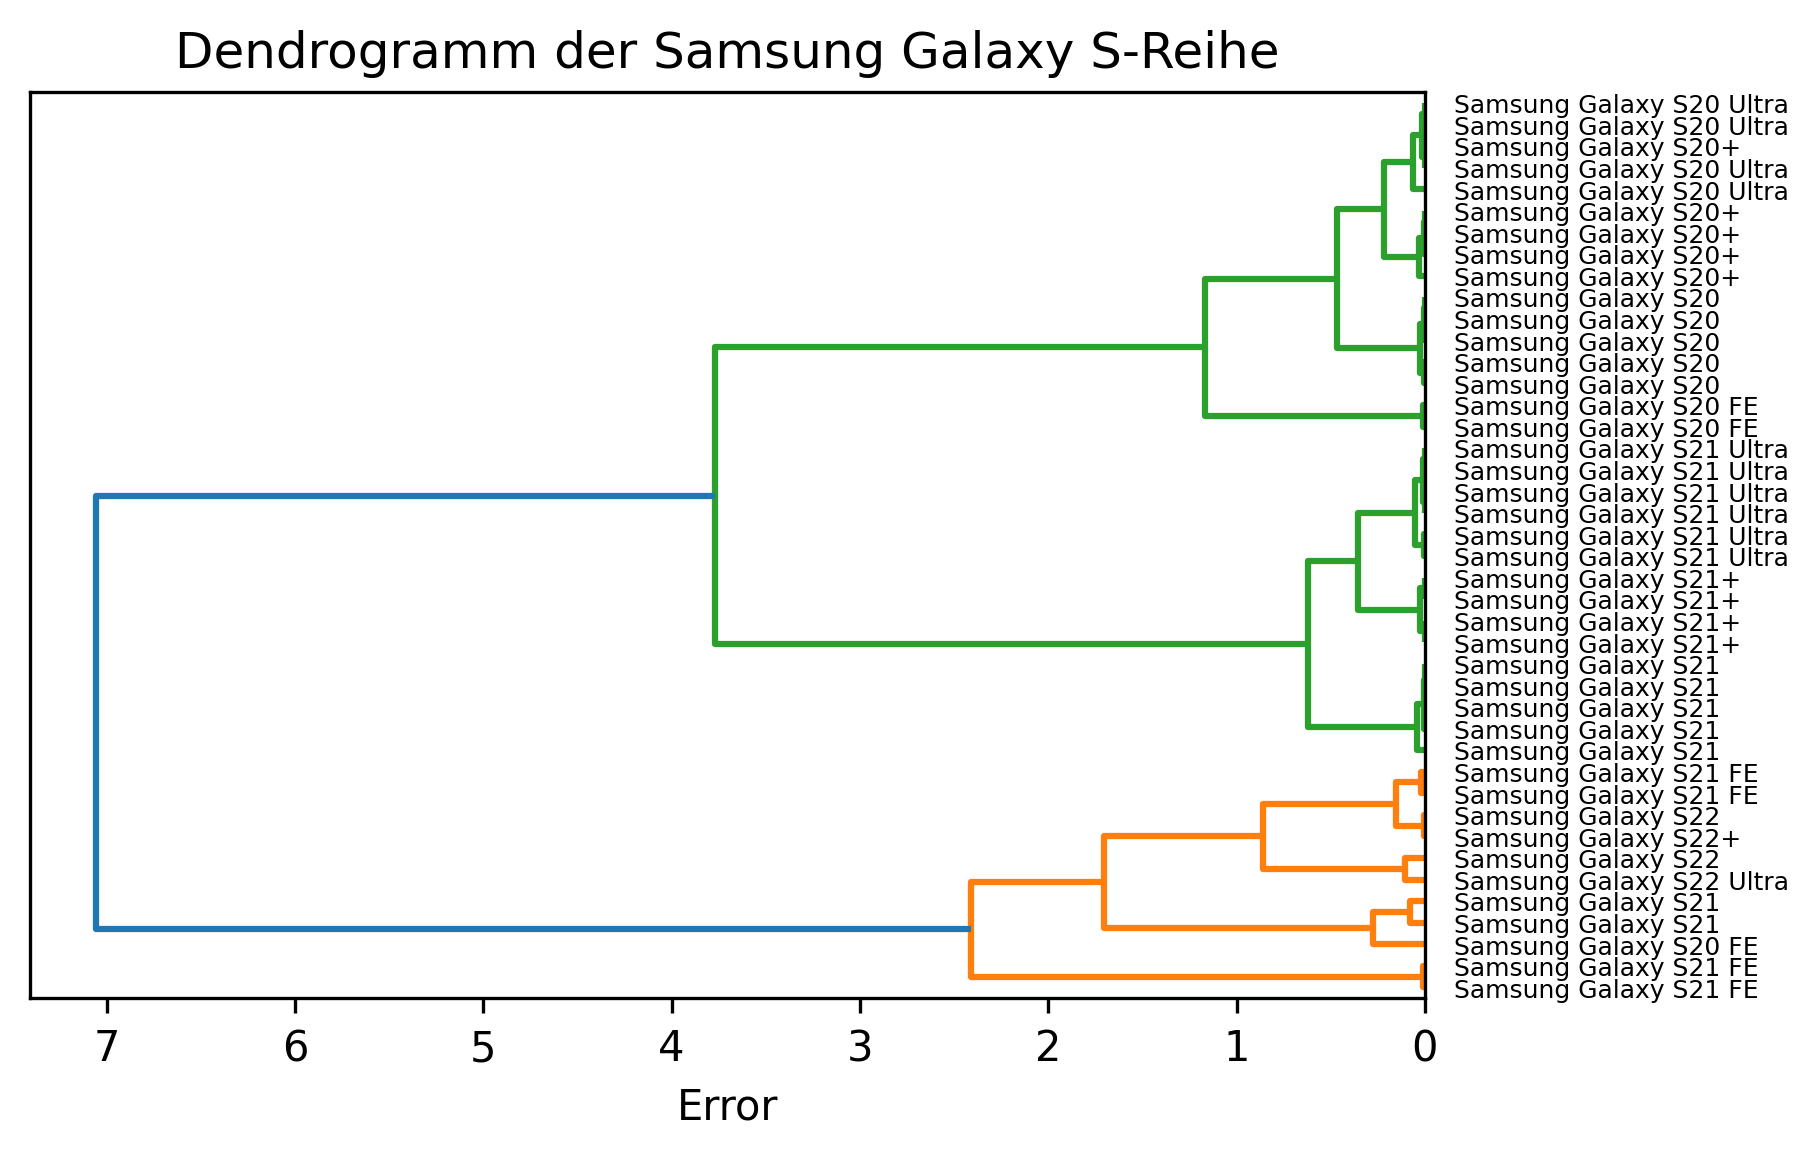

In [20]:
map_label = {
    "s20": "S20",
    "s20_plus": "S20+",
    "s20_ultra": "S20 Ultra",
    "s20_fe": "S20 FE",
    "s21": "S21",
    "s21_plus": "S21+",
    "s21_ultra": "S21 Ultra",
    "s21_fe": "S21 FE",
    "s22": "S22",
    "s22_plus": "S22+",
    "s22_ultra": "S22 Ultra",
}
labels_named = products_df[ac.KEY_CATEGORIES].map(lambda x: "Samsung Galaxy "+map_label[x[-1]]).to_list()

plt.title("Dendrogramm der Samsung Galaxy S-Reihe")
plt.xlabel("Error")
dendrogram(bik.dendrogram_matrix, labels=labels_named, leaf_font_size=6, orientation="left")

In [21]:
pd.DataFrame({
    "count": products_df[ac.KEY_ID].to_list(),
    "generation": labels_want_generations,
    "cluster": bik.labels_flat(k_generations),
}).groupby(["generation", "cluster"]).count().sort_values(["generation", "count"], ascending=[True, False])

count
generation cluster       
s20        0           16
           1            1
s21        2           15
           1            6
s22        1            4

In [22]:
pd.DataFrame({
    "count": products_df[ac.KEY_ID].to_list(),
    "models": labels_want_models,
    "cluster": bik.labels_flat(k_models),
}).groupby(["models", "cluster"]).count().sort_values(["models", "count"], ascending=[True, False])

count
models    cluster       
s20       8            5
s20_fe    5            2
          10           1
s20_plus  0            5
s20_ultra 0            4
s21       7            5
          4            2
s21_fe    1            2
          3            2
s21_plus  9            4
s21_ultra 2            6
s22       1            1
          6            1
s22_plus  1            1
s22_ultra 6            1